In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

if not os.path.exists('ocp'):
     !git clone https://github.com/Open-Catalyst-Project/ocp.git
os.chdir('ocp')
!pip -q install  lmdb pymatgen==2023.5.10 ase==3.22.1 orjson e3nn==0.2.6 wandb
!pip install submitit

2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ocp'...
remote: Enumerating objects: 36434, done.
remote: Counting objects: 100% (14549/14549), done.
remote: Compressing objects: 100% (3728/3728), done.
remote: Total 36434 (delta 7629), reused 13460 (delta 7026), pack-reused 21885
Receiving objects: 100% (36434/36434), 299.24 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (20195/20195), done.
Updating files: 100% (555/555), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/

In [3]:
!git clone https://github.com/Open-Catalyst-Project/ocp.git

Cloning into 'ocp'...
remote: Enumerating objects: 36434, done.
remote: Counting objects: 100% (14549/14549), done.
remote: Compressing objects: 100% (3728/3728), done.
remote: Total 36434 (delta 7629), reused 13460 (delta 7026), pack-reused 21885
Receiving objects: 100% (36434/36434), 299.24 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (20195/20195), done.
Updating files: 100% (555/555), done.


In [4]:
import sys
sys.path.append('/content/ocp/ocp/src')
sys.path.append('/content/ocp/ocp/src/fairchem')
sys.path.append('/content/ocp/ocp/src/fairchem/core')


In [5]:
from fairchem.core.datasets import SinglePointLmdbDataset
from fairchem.core.preprocessing import AtomsToGraphs
from fairchem.core.datasets import data_list_collater
from fairchem.core.common.relaxation.ase_utils import OCPCalculator


In [6]:
import json, zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

from ase.io import read

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from fairchem.core.datasets import SinglePointLmdbDataset
from fairchem.core.preprocessing import AtomsToGraphs
from fairchem.core.datasets import data_list_collater
from fairchem.core.common.relaxation.ase_utils import OCPCalculator



In [7]:
import sys
import os
import json
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from ase.io import read
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import urllib
from pathlib import Path
import requests
import numba
import ase
import e3nn
import pymatgen.core as pc
import torch
import torch.cuda as tc
import torch_geometric as tg
import platform
import psutil
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper
import contextlib
from io import StringIO
from ase.db import connect

# Update the Python path to include the necessary directories
sys.path.append('/content/ocp/src')
sys.path.append('/content/ocp/src/fairchem')
sys.path.append('/content/ocp/src/fairchem/core')

# Correct the imports based on the actual directory structure
from fairchem.core.datasets import SinglePointLmdbDataset
from fairchem.core.preprocessing import AtomsToGraphs
from fairchem.core.datasets import data_list_collater
from fairchem.core.common.relaxation.ase_utils import OCPCalculator

def ocp_root():
    """Return the root directory of the installed ocp package."""
    return Path(om.__file__).parent.parent

def ocp_main():
    """Return the path to ocp main.py"""
    return ocp_root() / "main.py"

def describe_ocp():
    """Print some system information that could be useful in debugging."""
    print(sys.executable, sys.version)
    print(f'ocp is installed at {ocp_root()}')

    commit_hash = (
            subprocess.check_output(
                    [
                        "git",
                        "-C",
                        om.__path__[0],
                        "describe",
                        "--always",
                    ]
                )
                .strip()
                .decode("ascii")
            )
    print(f'ocp repo is at git commit: {commit_hash}')
    print(f'numba: {numba.__version__}')
    print(f'numpy: {np.version.version}')
    print(f'ase: {ase.__version__}')
    print(f'e3nn: {e3nn.__version__}')
    print(f'pymatgen: {pc.__version__}')
    print(f'torch: {torch.__version__}')
    print(f'torch.version.cuda: {torch.version.cuda}')
    print(f'torch.cuda: is_available: {tc.is_available()}')
    if tc.is_available():
        print('  __CUDNN VERSION:', torch.backends.cudnn.version())
        print('  __Number CUDA Devices:', torch.cuda.device_count())
        print('  __CUDA Device Name:', torch.cuda.get_device_name(0))
        print('  __CUDA Device Total Memory [GB]:', torch.cuda.get_device_properties(0).total_memory/1e9)
    print(f'torch geometric: {tg.__version__}')
    print()
    print(f'Platform: {platform.platform()}')
    print(f'  Processor: {platform.processor()}')
    print(f'  Virtual memory: {psutil.virtual_memory()}')
    print(f'  Swap memory: {psutil.swap_memory()}')
    print(f'  Disk usage: {psutil.disk_usage("/")}')
checkpoints = {
    # Open Catalyst 2020 (OC20)
    'CGCNN 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_200k.pt',
    'CGCNN 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_2M.pt',
    'CGCNN 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_20M.pt',
    'CGCNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_all.pt',
    'DimeNet 200k' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_200k.pt',
    'DimeNet 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_2M.pt',
    'SchNet 200k'  :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_200k.pt',
    'SchNet 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_2M.pt',
    'SchNet 20M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_20M.pt',
    'SchNet All'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_all_large.pt',
    'DimeNet++ 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_200k.pt',
    'DimeNet++ 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_2M.pt',
    'DimeNet++ 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_20M.pt',
    'DimeNet++ All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_all.pt',
    'SpinConv 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/spinconv_force_centric_2M.pt',
    'SpinConv All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/spinconv_force_centric_all.pt',
    'GemNet-dT 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/gemnet_t_direct_h512_2M.pt',
    'GemNet-dT All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt',
    'PaiNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_05/s2ef/painn_h512_s2ef_all.pt',
    'GemNet-OC 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_2M.pt',
    'GemNet-OC All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_all.pt',
    'GemNet-OC All+MD'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt',
    'GemNet-OC-Large All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_large_s2ef_all_md.pt',
    'SCN 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t1_b1_s2ef_2M.pt',
    'SCN-t4-b2 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t4_b2_s2ef_2M.pt',
    'SCN All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_all_md_s2ef.pt',
    'eSCN-L4-M2-Lay12 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l4_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_all_md_s2ef.pt',
    'eSCN-L6-M3-Lay20 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt',
    'EquiformerV2 (83M) 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_83M_2M.pt',
    'EquiformerV2 (31M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_31M_ec4_allmd.pt',
    'EquiformerV2 (153M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_153M_ec4_allmd.pt',
    # Open Catalyst 2022 (OC22)
    'GemNet-dT OC22'    : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gndt_oc22_all_s2ef.pt',
    'GemNet-OC OC22'    : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt',
    'GemNet-OC OC20+OC22'    : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_05/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC OC20->OC22'    : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_finetune_all_s2ef.pt',
    'equiformer' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_10/oc22/s2ef/eq2_121M_e4_f100_oc22_s2ef.pt',
    'pt_ceo2_ce7_ep200' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/fine-tuning/checkpoints/2023-11-14-16-21-20-lr_5e-07_epochs_200/checkpoint.pt',
    'pt_ceo2_ce5_ep100_add' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/additional_data_training/2023-11-16-02-42-08-lr_0.0005_epochs_100/checkpoint.pt',
}

def list_checkpoints():
    """List checkpoints that are available to download."""
    print('See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.')
    for key in checkpoints:
        print(key)
    print('Copy one of these keys to get_checkpoint(key) to download it.')

def get_checkpoint(key):
    """Download a checkpoint.
    key: string in checkpoints.
    Returns name of checkpoint that was saved.
    """
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception('No url found for {key}')
    print('url', url)
    pt = Path(urllib.parse.urlparse(url).path).name
    print('pt', pt)

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt

def train_test_val_split(ase_db, ttv=(0.8, 0.1, .1), files=('train.db', 'test.db', 'val.db'), seed=42):
    """Split an ase db into train, test and validation dbs.

    ase_db: path to an ase db containing all the data.
    ttv: a tuple containing the fraction of train, test and val data. This will be normalized.
    files: a tuple of filenames to write the splits into. An exception is raised if these exist.
           You should delete them first.
    seed: an integer for the random number generator seed

    Returns the absolute path to files.
    """

    for db in files:
        if os.path.exists(db):
            raise Exception('{db} exists. Please delete it before proceeding.')

    src = connect(ase_db)
    N = src.count()

    ttv = np.array(ttv)
    ttv /= ttv.sum()

    train_end = int(N * ttv[0])
    test_end = train_end + int(N * ttv[1])

    train = connect(files[0])
    test = connect(files[1])
    val = connect(files[2])

    ids = np.arange(1, N + 1)
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(ids)

    for _id in ids[0:train_end]:
        row = src.get(id=int(_id))
        train.write(row.toatoms())

    for _id in ids[train_end:test_end]:
        row = src.get(id=int(_id))
        test.write(row.toatoms())

    for _id in ids[test_end:]:
        row = src.get(id=int(_id))
        val.write(row.toatoms())

    return [Path(f).absolute() for f in files]

def generate_yml_config(checkpoint_path, yml='run.yml', delete=(), update=()):
    """Generate a yml config file from an existing checkpoint file.

    checkpoint_path: string to path of an existing checkpoint
    yml: name of file to write to.
    pop: list of keys to remove from the config
    update: dictionary of key:values to update

    Use a dot notation in update.

    Returns an absolute path to the generated yml file.
    """

    # You can't just read in the checkpoint with torch. The calculator does some things to it.
    # Rather than recreate that here I just reuse the calculator machinery. I don't want to
    # see the output though, so I capture it.

    with contextlib.redirect_stdout(StringIO()) as _:
        config = OCPCalculator(checkpoint_path=checkpoint_path).config # there seems an parameter checkpoint changed in OCPcalculator (s.choung)

    for key in delete:
        if key in config and len(key.split('.')) == 1:
            del config[key]
        else:
            keys = key.split('.')
            if keys[0] in config:
                d = config[keys[0]]
            else:
                continue
            if isinstance(d, dict):
                for k in keys[1:]:
                    if isinstance(d[k], dict):
                        d = d[k]
                    else:
                        if k in d:
                            del d[k]

    def nested_set(dic, keys, value):
        for key in keys[:-1]:
            dic = dic.setdefault(key, {})
        dic[keys[-1]] = value

    for _key in update:
        keys = _key.split('.')
        nested_set(config, keys, update[_key])

    out = dump(config)
    with open(yml, 'wb') as f:
        f.write(out.encode('utf-8'))

    return Path(yml).absolute()

# Example usage of get_checkpoint function
gemnet = get_checkpoint('GemNet-OC OC22')


url https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt
pt gnoc_oc22_all_s2ef.pt


In [8]:
import sys
import os
import requests
from pathlib import Path
import urllib

# Add the correct path based on the location of ase_utils.py
sys.path.append('/content/ocp/ocp/src/fairchem/core')
sys.path.append('/content/ocp/src/fairchem/core')

# Verify if the path is added correctly
print(sys.path)

# Try the import
from common.relaxation.ase_utils import OCPCalculator

# Define the checkpoints and download function
checkpoints = {
    'GemNet-OC OC22': 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt'
}

def get_checkpoint(key):
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception(f'No url found for {key}')
    print('url', url)
    pt = Path(urllib.parse.urlparse(url).path).name
    print('pt', pt)

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt

# Download the checkpoint
gemnet = get_checkpoint('GemNet-OC OC22')


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/ocp/ocp/src', '/content/ocp/ocp/src/fairchem', '/content/ocp/ocp/src/fairchem/core', '/content/ocp/src', '/content/ocp/src/fairchem', '/content/ocp/src/fairchem/core', '/content/ocp/ocp/src/fairchem/core', '/content/ocp/src/fairchem/core']
url https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt
pt gnoc_oc22_all_s2ef.pt


In [9]:
calc = OCPCalculator(checkpoint_path=os.path.expanduser(gemnet), cpu=True)

In [10]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
import json
def stoich(data,i):
    data_string =data[i]['reactants']
    prod_string =data[i]['products']
    reactants_list = list(json.loads(data_string).keys())
    values_list = list(json.loads(data_string).values())
    product = list(json.loads(prod_string).keys())
    return values_list, reactants_list, product

def energy_cal(atoms, fmax=0.05):
    atoms.set_calculator(calc)
    tags = np.ones(len(atoms))
    atoms.set_tags(tags)
    print(tags)
    opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()
def status(proceed):
    num = int(proceed/5)
    return '🟩'*num+'⬜️'*(20-num)

In [11]:
!pip install ase pymatgen

In [12]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (3,228 kB/s)
debconf: unable to initialize frontend: Dialo

In [13]:
from ase import Atoms
from ase.io import Trajectory, write
from ase.build import bulk, surface, molecule, add_adsorbate, fcc111
from ase.constraints import ExpCellFilter, StrainFilter, FixAtoms, FixedPlane, FixBondLength
from ase.optimize import LBFGS, BFGS, FIRE
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.md import MDLogger
from ase.io.vasp import read_vasp

import pandas as pd
import ipywidgets as widgets
from IPython.display import display_png, Image as ImageWidget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import shutil

import glob
from pathlib import Path
from PIL import Image, ImageDraw

from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.vasp import Poscar
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor

import numpy as np
from scipy.spatial.distance import cdist

def visual(structure, index, max_size=(100, 100), stretch_y=1.0):
    renderer = write('./temp.pov', structure, rotation='90z,-90x')
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)
    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)

In [16]:
from pymatgen.io.vasp import Poscar
import os
import sys
import re, glob
import shutil
import time
import math
import numpy as np
from os import listdir
from os.path import isfile, join, isdir, expanduser, basename
from tabulate import tabulate
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import Lattice, SlabGenerator, Structure, generate_all_slabs
from pymatgen.io.vasp.inputs import Poscar
from pymatgen.io.ase import AseAtomsAdaptor
from ase.constraints import FixAtoms

def slab_generation_fun(bulk,facet,supercell_size,thick):
    slabgen = SlabGenerator(bulk, facet, thick, 20) #miller, min-slab size, vaccum size in angstroms
    all_slabs = slabgen.get_slabs()
    for slabs in all_slabs:
      slabs.make_supercell(supercell_size)

    print(f"The {facet} slab has %s termination." % (len(all_slabs)))
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in all_slabs] # ase transformation
    for idx,slab_atoms in enumerate(slab_atoms_list):
      slab=slab_atoms.copy()
      min_pos_z = np.min(slab.positions, axis=0)[2]
      slab.set_positions(slab.positions - [0, 0, min_pos_z-3])
      # fix atoms half
      ase_slab_z_positions=[atom.position[2] for atom in slab]
      c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] <np.median(ase_slab_z_positions)])
      slab.set_constraint(c)
      print(slab)
      #visual(slab, './', (300, 300),1)
      #write(f'/content/drive/MyDrive/for_woonsuk/test_{idx}_{facet}.vasp',slab)
    return slab_atoms_list

##########Bulk 넣기############
temp = Poscar.from_file("/content/drive/MyDrive/slab_generation/4periodMO/Mn/POSCAR")
ceo2_bulk = temp.structure
supercell_size=[[1,1,1]]
facets = [(1,1,0)]
thickness = [14]
##############################
slab_list_list=[]
for idx,facet in enumerate(facets):
  slab_list = slab_generation_fun(ceo2_bulk,facets[idx],supercell_size[idx],thickness[idx])
  slab_list_list.append(slab_list)


The (1, 1, 0) slab has 2 termination.
Atoms(symbols='Mn2O4Mn2O4Mn2O4Mn2O4Mn2O4', pbc=True, cell=[[2.8670778275, 0.0, 1.7555788421771112e-16], [7.076412306692104e-16, 4.4004182816, -4.4004182815999995], [0.0, 0.0, 52.805019379200004]], bulk_equivalent=..., bulk_wyckoff=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17]))
Atoms(symbols='Mn2O4Mn2O4Mn2O4Mn2O4Mn2O4', pbc=True, cell=[[2.8670778275, 0.0, 1.7555788421771112e-16], [7.076412306692104e-16, 4.4004182816, -4.4004182815999995], [0.0, 0.0, 52.805019379200004]], bulk_equivalent=..., bulk_wyckoff=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16]))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
       Step     Time          Energy         fmax
LBFGS:    0 07:16:07     -205.910782        2.0669
LBFGS:    1 07:16:09     -206.143219        1.8789
LBFGS:    2 07:16:11     -206.987869        1.0929
LBFGS:    3 07:16:13     -207.135864        0.9568
LBFGS:    4 07:16:15     -207.240753        1.0335
LBFGS:    5 07:16:17     -207.210449        0.8764
LBFGS:    6 07:16:21     -207.185913        0.6353
LBFGS:    7 07:16:24     -207.189636        0.7062
LBFGS:    8 07:16:26     -207.299927        0.6954
LBFGS:    9 07:16:28     -207.455933        0.3907
LBFGS:   10 07:16:30     -207.540298        0.3443
LBFGS:   11 07:16:32     -207.634872        0.2427
LBFGS:   12 07:16:34     -207.709778        0.2102
LBFGS:   13 07:16:37     -207.744186        0.2085
LBFGS:   14 07:16:40     -207.762970        0.1791
LBFGS:   15 07:16:42     -207.732513        0.1445
LBFGS:   16 07:16:44     -207.711929     

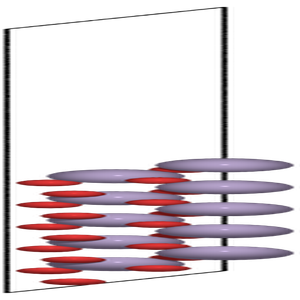

========after========


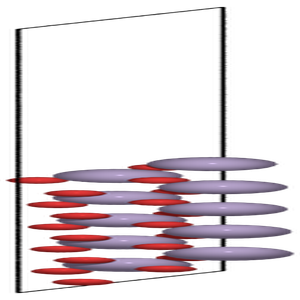

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
       Step     Time          Energy         fmax
LBFGS:    0 07:16:57     -208.471985        1.4720
LBFGS:    1 07:16:59     -208.687057        0.8954
LBFGS:    2 07:17:01     -209.075562        0.6388
LBFGS:    3 07:17:03     -209.211670        0.7653
LBFGS:    4 07:17:06     -209.258026        0.8191
LBFGS:    5 07:17:09     -209.322662        0.5746
LBFGS:    6 07:17:11     -209.277542        0.5122
LBFGS:    7 07:17:13     -209.184143        0.4048
LBFGS:    8 07:17:15     -209.142776        0.5384
LBFGS:    9 07:17:17     -209.172531        0.6136
LBFGS:   10 07:17:19     -209.348083        0.4187
LBFGS:   11 07:17:21     -209.503601        0.4879
LBFGS:   12 07:17:24     -209.608948        0.4180
LBFGS:   13 07:17:26     -209.723984        0.2947
LBFGS:   14 07:17:28     -209.814407        0.1754
LBFGS:   15 07:17:30     -209.854218        0.1537
LBFGS:   16 07:17:32     -209.832581     

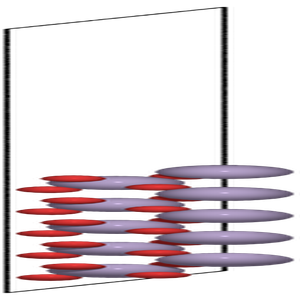

========after========


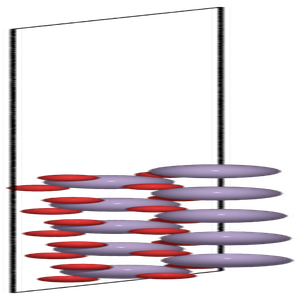

In [17]:
for idx,slab_list in enumerate(slab_list_list):
  for idx2,slab in enumerate(slab_list):
    atoms = slab.copy()
    tags = np.ones(len(atoms))
    atoms.set_tags(tags)
    atoms.set_calculator(calc)
    tot_energy = energy_cal(atoms, fmax=0.05)  # Adjust fmax as needed
    print(f'========before========')
    visual(slab, './', (300, 300),1)
    print(f'========after========')
    visual(atoms, './', (300, 300),1)
    write(f'/content/drive/MyDrive/slab_generation/4periodMO/Mn/{idx2}_{facets[idx]}_relaxed.vasp',atoms)
